In [1]:
!pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in c:\users\sudha\anaconda3\lib\site-packages (2.2.2)


In [2]:
!pip install plotnine

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import calendar
from sklearn.preprocessing import MinMaxScaler
from category_encoders.target_encoder import TargetEncoder
import missingno as msno
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from plotnine import *

from sklearn.decomposition import PCA

In [4]:
mainpath='https://raw.githubusercontent.com/syeelarthi/Footfall-prediction-code/master/'
df1 = pd.read_csv(mainpath+'footfall_Part1.csv')
df2 = pd.read_csv(mainpath+'footfall_Part2.csv')
df3 = pd.read_csv(mainpath+'footfall_Part3.csv')
df_foot_fall =pd.concat([df1,df2,df3])
df_weather_data= pd.read_csv(mainpath+'overall_weather.csv')
df_easter_sunday_holiday_data= pd.read_csv(mainpath+'Easter-Sundays.csv')
df_university_long_holidays_data= pd.read_csv(mainpath+'uni_hols_long.csv')
df_UK_bank_holidays_data= pd.read_csv(mainpath+'UKbankholidays.csv')
df_school_long_holidays_data= pd.read_csv(mainpath+'school_hols_long.csv')

In [5]:
class MultiColumnEncoder:
    def __init__(self,Categoricalcolumns = None,includedcolumns=None):
        self.columns = Categoricalcolumns # array of column names to encode
        self.included_cols = includedcolumns

    def fit(self,X,y=None):
        return self # not relevant here

    def transform_LabelEncoder(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def onehot_encode_integers(self, df):
        df = df.copy()
        df_encoded = pd.get_dummies(df, columns = self.included_cols)
        return df_encoded
 
    def fit_transform(self,X,y=None,encoding_type = 'target_encoding'):
      if encoding_type == 'onehot_encoding':
        return self.onehot_encode_integers(X) 
      elif encoding_type == 'target_encoding':
        return self.target_encoding(X,y)

    def target_encoding(self,X, target_column):
        return TargetEncoder(cols=self.included_cols).fit_transform(X,X[target_column])


In [6]:
class Lagging:  
  def __init__(self, location_name_list=None, n_timesteps=7, n_forecast_steps=1):
      self.n_timesteps = n_timesteps
      self.location_name_list = location_name_list # array of locations
      self.n_forecast_steps = n_forecast_steps

  def createforecastTargetVariables(self, df):
    # copy the InCount to other forecast columns
    for forecast_step in range(1, self.n_forecast_steps+1): 
      df['InCountTotal'+'_forecast'+str(forecast_step)] = df['InCountTotal']
          
    #update multistep output variables
    for i in range(0, df.shape[0]-self.n_forecast_steps):
      for forecast_step in range(1, self.n_forecast_steps+1): 
        df['InCountTotal'+'_forecast'+str(forecast_step)][i] = df['InCountTotal'][i+forecast_step]
      
    #remove the last nforecast rows as these do not have proper values after creating the forecast variables
    df.drop(df.tail(self.n_forecast_steps).index,inplace=True)
    return df

  def createLagVariables(self,df): #Create lag variables of size=n_timesteps
      if location_wise_data == True:#location wise data
        for location in self.location_name_list:
            location = 'InCount'+location
            for lag in range(1, self.n_timesteps+1):
                df[location+'_lag'+str(lag)] = df[location].shift(periods=lag)
      else:# totalincount only
        for lag in range(1, self.n_timesteps):
            df['InCountTotal'+'_lag'+str(lag)] = df['InCountTotal'].shift(periods=lag)
        
      df.dropna(inplace = True)
      return df

  def createLagDiffVariables(self,df,location_wise_data = True): #Create lag variables of size=n_timesteps
    if location_wise_data == True:#location wise data
      for location in self.location_name_list:
        location = 'InCount'+location
        for lag in range(1, self.n_timesteps+1):
          df[location+'_lag'+str(lag)] = df[location].diff(periods=lag)
    else:# totalincount only
      for lag in range(1, self.n_timesteps+1):
          df['InCountTotal'+'_lag'+str(lag)] = df['InCountTotal'].diff(periods=lag)
    
    df.dropna(inplace = True)
    return df

In [7]:
class pre_processing:
  def __init__(self,data_frame):
        self.data_frame = data_frame # which data_frame to pre-process
        self.location_name_list = []
        self.location_name_col_list=[]
        self.scaler_target = MinMaxScaler(feature_range = (0, 1))
        self.scaler_input = MinMaxScaler(feature_range = (0,1))
  def cleanup_data(self, col_name='Date'):
     # there is a white space in one of the date values in Easter holidays list. We need to remove that
     if( col_name in self.data_frame.columns):
        self.data_frame[col_name] = self.data_frame[col_name].str.replace(' ', '')
     return self.data_frame 

  def converttocategory(self,cols):
        for col in cols:
            self.data_frame[col]=self.data_frame[col].astype('category')
        return self.data_frame

  def aggregate(self,group_by_cols, retain_list=None): 
      '''
      aggregate the column values based on conditions
      ''' 
      retain_list = {}
      # add all the location name columns to retain list
      for location_name in self.location_name_list:
        key = 'InCount'+location_name
        retain_list[key] = 'sum'
      # now aggregate based on Date
      self.data_frame = self.data_frame.groupby(group_by_cols).agg(retain_list).reset_index()
      return self.data_frame

  def reshape_location_name(self, group_by_cols, target_col='InCount'):# Review this
      
      data_temp_df = pd.DataFrame(data=self.data_frame[['Date','Weekday','Month']])
      data_temp_df.drop_duplicates('Date', inplace=True)
      
      self.location_name_list = self.data_frame["LocationName"].unique()

      self.data_frame = self.data_frame.pivot_table(index=group_by_cols, columns='LocationName',values=[target_col]).reset_index()
      self.data_frame.columns = [''.join(col) for col in self.data_frame.columns]
            
      return self.data_frame.merge(data_temp_df, on='Date', how='inner')

  def encode_variables(self,included_cols, target_variable = 'InCountTotal', encoding_type = 'target_encoding'):
      '''
      categorical/target encoding of the column values
      '''
      self.data_frame = MultiColumnEncoder(includedcolumns = included_cols).fit_transform(self.data_frame,target_variable,encoding_type = 'target_encoding')
      return self.data_frame
  def imputeData(self): 
      # fill missing values with mean column values as only missing column i see is InCountAlbionStSouth
      #print('impute data')
      self.data_frame.fillna(self.data_frame.mean(), inplace=True)
      return self.data_frame
  def pre_process(self,data_frame_type='Foot_Fall'):
      '''
      for different data frame types, do the different pre-processibg
      ''' 
      
      if(data_frame_type=='Foot_Fall'):
        
        '''group_by_cols = ['Date','Hour']
        
        self.data_frame = self.reshape_location_name(group_by_cols)
        self.data_frame = self.imputeData()   
        retain_list = {'Weekday': 'first', 'Month': 'first'}
        # add all the location name columns to retain list
        for location_name in self.location_name_list:
          key = 'InCount'+location_name
          retain_list[key] = 'sum'
        # now aggregate based on Date
        self.data_frame = self.aggregate(['Date'],retain_list) '''

      elif (data_frame_type == 'EasterSunday'):
          # cleanup the date columns
          self.data_frame  = self.cleanup_data(col_name='Date')
      
      return self.data_frame
  def pre_process_date_related_columns(self):
      for i in range(len(self.data_frame)):
          self.data_frame['Date'].iloc[i]=self.data_frame['Date'].iloc[i].replace('Jan-', '01-20').replace('Feb-', '02-20').replace('Mar-', '03-20').replace('Apr-', '04-20').replace('May-', '05-20').replace('Jun-', '06-20').replace('Jul-', '07-20').replace('Aug-', '08-20').replace('Sep-', '09-20').replace('Oct-', '10-20').replace('Nov-', '11-20').replace('Dec-', '12-20')

      self.data_frame['Date'] = pd.to_datetime(self.data_frame['Date'], format = '%d-%m-%Y').dt.strftime('%d/%m/%Y')
      self.data_frame['Month']=pd.to_datetime(self.data_frame['Date'], format = '%d/%m/%Y').dt.month
      self.data_frame['Year']=pd.to_datetime(self.data_frame['Date'], format = '%d/%m/%Y').dt.year
      self.data_frame['Day']=pd.to_datetime(self.data_frame['Date'], format = '%d/%m/%Y').dt.day
      self.data_frame['Weekday']=pd.to_datetime(self.data_frame['Date'], format = '%d/%m/%Y').dt.weekday
      self.data_frame['Week_no']=pd.to_datetime(self.data_frame['Date'], format = '%d/%m/%Y').dt.week
      
      for i in range(len(self.data_frame)):
          self.data_frame['Weekday'].iloc[i]=calendar.day_name[self.data_frame['Weekday'].iloc[i]]

      self.data_frame['Date'] = pd.to_datetime(self.data_frame['Date'], format = '%d/%m/%Y').dt.strftime('%d-%m-%Y')
  
  def pre_process_date_related_columns_1(self):
    #self.data_frame['Date']=self.data_frame['Date'].replace('Jan-', '01-20').replace('Feb-', '02-20').replace('Mar-', '03-20').replace('Apr-', '04-20').replace('May-', '05-20').replace('Jun-', '06-20').replace('Jul-', '07-20').replace('Aug-', '08-20').replace('Sep-', '09-20').replace('Oct-', '10-20').replace('Nov-', '11-20').replace('Dec-', '12-20') 
    self.data_frame['Date']=pd.to_datetime(self.data_frame['Date'])
    self.data_frame['Year'] = pd.DatetimeIndex(self.data_frame['Date']).year
    self.data_frame['Day'] = pd.DatetimeIndex(self.data_frame['Date']).month
    self.data_frame['Weekday'] = pd.DatetimeIndex(self.data_frame['Date']).weekday
    self.data_frame['Week_no'] = pd.DatetimeIndex(self.data_frame['Date']).week
    self.data_frame['Weekday']=pd.DatetimeIndex(self.data_frame['Date']).day_name()

  def merge_data(self, data_to_merge, col_by ='Date'):
      self.data_frame = self.data_frame.merge(data_to_merge, how='inner', left_on=col_by, right_on=col_by)
      return self.data_frame
  def add_new_column(self, data_to_add, new_col_name, source_date_format = '%d-%m-%Y', destination_date_format = '%m-%d-%Y' ):
      self.data_frame['Tempcolumn'] = pd.to_datetime(self.data_frame['Date'], format = source_date_format).dt.strftime('%d/%m/%Y')

      temp_data = data_to_add.copy()

      temp_data['Tempcolumn'] = pd.to_datetime(temp_data['Date'],format = destination_date_format).dt.strftime('%d/%m/%Y')

      self.data_frame[new_col_name] = (self.data_frame.set_index(['Tempcolumn']).index.isin(temp_data.set_index(['Tempcolumn']).index)).astype(int)
      temp_data.drop(['Tempcolumn'],axis=1)

      self.data_frame.drop(['Tempcolumn'],axis=1, inplace=True)
      
      return self.data_frame

  def createTimeSeries(self):
      self.data_frame["DateTime"] = pd.to_datetime(self.data_frame.Date.astype(str))
      self.data_frame = self.data_frame.set_index("DateTime")
      self.data_frame.drop(['Date'], inplace=True, axis=1)
      self.data_frame = self.data_frame.sort_index()
      return self.data_frame
 
  def checkForMissingValues(self, location_name_list):
        for location in location_name_list:
            self.data_frame.loc[self.data_frame[self.data_frame['InCount'+location]==0].index,'InCount'+location] = np.NaN
        return self.data_frame
  
  def createLag_ForecastVariables(self,location_name_list=None, n_timesteps=7,n_forecast_steps = 1, location_wise_data = True):
      nLagClass = Lagging(location_name_list,n_timesteps, n_forecast_steps)
      #self.data_frame = nLagClass.createLagVariables(self.data_frame)
      # create lag data for total mall incount
      self.data_frame = nLagClass.createLagDiffVariables(self.data_frame, location_wise_data = location_wise_data)
      self.data_frame = nLagClass.createforecastTargetVariables(self.data_frame)
      
      return self.data_frame

  def addTotalIncountColumn(self):
    self.location_name_col_list=['InCount'+x for x in self.location_name_list]
    self.data_frame['InCountTotal'] = self.data_frame[self.location_name_col_list].sum(axis=1)
    self.data_frame['InCountTotal'] = self.data_frame['InCountTotal'].astype(int)
    return self.data_frame

  def normalizeTargetVariable(self):
    #print('normalization')
    self.data_frame[['InCountTotal']] = self.scaler_target.fit_transform(self.data_frame[['InCountTotal']])

    location_name_col_list=['InCount'+x for x in self.location_name_list]
    for location_col in location_name_col_list:
      self.data_frame[[location_col]] = self.scaler_target.fit_transform(self.data_frame[[location_col]])
    return self.data_frame

  def normalizeTargetVariable_step1(self):
    #print('normalization')
    self.data_frame[['InCount']] = self.scaler_target.fit_transform(self.data_frame[['InCount']])
    return self.data_frame

  def normalizeInputVariables(self, included_cols=None):
     #print('normalize input variables')
     self.data_frame[included_cols] = self.scaler_input.fit_transform(self.data_frame[included_cols])
     return self.data_frame

  def visualizeMissingValues(self):
       #print('missing values visualization')
       msno.bar(self.data_frame)
        
  #Imputation using KNN      
  def imputeDataWithKnn(self):
    X = self.data_frame[['InCountCommercialStBarratts', 'InCountCommercialStLush']]
    imputer = KNNImputer(n_neighbors=2)
    imputed_df = imputer.fit_transform(X)
    imputed_df = pd.DataFrame(imputed_df, columns=X.columns)
    #print(imputed_df)
    #print(self.data_frame['InCountCommercialStBarratts'])
    self.data_frame['InCountCommercialStBarratts'] = imputed_df.values
    return self.data_frame

  #imputation using IterativeImputer which works similar to MICE
  def imputeDataWithIterativeImputation(self):
    X = self.data_frame[['InCountCommercialStBarratts', 'InCountCommercialStLush']]
    imputer = IterativeImputer(max_iter=10, verbose=0)
    imputed_df = imputer.fit_transform(X)
    imputed_df = pd.DataFrame(imputed_df, columns=X.columns)
    #print(imputed_df)
    #print(self.data_frame['InCountCommercialStBarratts'])
    self.data_frame['InCountCommercialStBarratts'] = imputed_df.values
    return self.data_frame 



In [8]:
def do_pre_processing_for_DBSCAN():
  global df_easter_sunday_holiday_data, df_university_long_holidays_data, df_school_long_holidays_data, df_UK_bank_holidays_data

  # process the main data set
  pre_process_dbscan = pre_processing(df_foot_fall)
  
  pre_process_dbscan.normalizeTargetVariable_step1()

  # Merge weather data and foot fall data based on date
  data_DBScan = pre_process_dbscan.merge_data(df_weather_data, col_by='Date')
  
  print(data_DBScan.head())

  # add new column for EasterHolidays
  pre_process_easter_sunday_data1 = pre_processing(df_easter_sunday_holiday_data)
  df_easter_sunday_holiday_data = pre_process_easter_sunday_data1.pre_process(data_frame_type='EasterSunday') 
  pre_process_dbscan.add_new_column(df_easter_sunday_holiday_data,'EasterSundayHoliday', destination_date_format = '%m-%d-%Y' )
  
  # add a new column for university holidays
  pre_process_dbscan.add_new_column(df_university_long_holidays_data,'University_holidays', destination_date_format = '%d-%b-%y' )
  
  # add a new column for School holidays
  pre_process_dbscan.add_new_column(df_school_long_holidays_data,'School_holidays', destination_date_format = '%d-%b-%y' )

  # add a new column for UK Bank holidays
  pre_process_dbscan.add_new_column(df_UK_bank_holidays_data,'UKBankHoliday', destination_date_format = '%d-%b-%y' )
  
  # encode the variable - categorial with one-hotencoding or target encoding
  pre_process_dbscan.encode_variables(['Hour','Weekday','Month','Day','Year', 'week_no'], target_variable = 'InCount', encoding_type = 'target_encoding')
  pre_process_dbscan.converttocategory(['abnormal_rain', 'high_temp', 'low_temp', 'high_wind','EasterSundayHoliday', 'University_holidays', 'School_holidays','UKBankHoliday'])

  input_cols = ['Hour','Month','Weekday','mean_temp','rain','wind_speed','abnormal_rain','high_temp','low_temp','high_wind','EasterSundayHoliday',
                  'University_holidays','School_holidays','UKBankHoliday', 'InCount']
  # normalize input variables
  data_DBScan = pre_process_dbscan.normalizeInputVariables(['mean_temp','rain','wind_speed'])
  data_DBScan.index=data_DBScan['Date']
  data_DBScan = data_DBScan[input_cols]
  return data_DBScan

In [9]:
data_DBScan = do_pre_processing_for_DBSCAN()

         Date   InCount  BRCWeek LocationName  Hour   Weekday    NewDate  \
0  01-01-2011  0.028153       52     Briggate     0  Saturday  01-Jan-11   
1  01-01-2011  0.032644       52     Briggate     1  Saturday  01-Jan-11   
2  01-01-2011  0.032240       52     Briggate     2  Saturday  01-Jan-11   
3  01-01-2011  0.021847       52     Briggate     3  Saturday  01-Jan-11   
4  01-01-2011  0.017154       52     Briggate     4  Saturday  01-Jan-11   

   Month  Year  Day  ...  Week_yr          Hour_yr week_no mean_temp  rain  \
0      1  2011    1  ...  00-2011  00, 01-Jan-2011       1       0.0   0.0   
1      1  2011    1  ...  00-2011  00, 01-Jan-2011       1       0.0   0.0   
2      1  2011    1  ...  00-2011  00, 01-Jan-2011       1       0.0   0.0   
3      1  2011    1  ...  00-2011  00, 01-Jan-2011       1       0.0   0.0   
4      1  2011    1  ...  00-2011  00, 01-Jan-2011       1       0.0   0.0   

   wind_speed  abnormal_rain  high_temp  low_temp  high_wind  
0         0

In [12]:
def findeps(dataframe,number_near,metrics='euclidean'):
      data_frame=dataframe.copy()
      ncol=len(data_frame.columns)

      # finding the distances based on nearest neighbour to find optimal eps

      print('Finding Distances')
      neigh = NearestNeighbors(n_neighbors=number_near,metric=metrics)
      nbrs = neigh.fit(np.array(data_frame).reshape(-1,ncol))
      distances, indices = nbrs.kneighbors(np.array(data_frame).reshape(-1,ncol))
      distance=[]
      print('Preparing final distance')
      for i in range (len(distances)):
        distance.append(np.sum(distances[i]))
      distance = np.sort(distance, axis=0)
      #distance = distance[:,1]
      # If plotted on a graph, a point with maximum curvature. , ie, a point with maximum slope gives the best eps
      maxslope=0
      neps=0
      diff=[] # A list to hold the differences in the distances
      print('Finding EPS')
      for i in range (len(distance)-1):
          slope=( (distance[i]-distance[i+1])/(indices[i][0]-indices[i+1][0]))
          if (slope<1 and maxslope<slope):
              maxslope=slope
              neps=distance[i]
      print('Optimal eps is ',neps)
      return neps
    
    
def findoutliers(dataframe,number_near,neps=0,metrics='euclidean',algo='LOF',npca=2):
      data_frame=dataframe.copy()
      print('Starting Outlier Identification')
      ncol=len(data_frame.columns)

      print('Checking if LOF has to be applied')
      if (algo=='LOF'):
        print('Applying LOF')
        clf = LocalOutlierFactor(n_neighbors=number_near)
        pred=clf.fit_predict(np.array(data_frame).reshape(-1,ncol))
        n_noise_ = list(pred).count(-1)
        data_frame['Lof_Outlier']=[1 if val ==-1 else 0 for val in pred]
        print('LOF Analysis')
        print('Estimated number of noise points: %d' % n_noise_)
      else:
        print('Applying DBSCAN')
        db=DBSCAN(eps=neps, min_samples=number_near,metric=metrics).fit(np.array(data_frame).reshape(-1,ncol))
        labels=db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        
        data_frame['DBSCAN_Outlier'] = [1 if val ==-1 else 0 for val in labels]
        print('DBSCAN Analysis')
        print('Optimal eps is ',neps)
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
      print('PCA Step')
      if (npca==2):
            pca = PCA(n_components=2)
            principalComponents = pca.fit_transform(data_frame)
            principalDf = pd.DataFrame(data = principalComponents, columns = ['D1','D2'])
            print(' End of PCA2 Step')
            data_frame['D1']=principalDf['D1'].values
            data_frame['D2']=principalDf['D2'].values
      else:
            pca = PCA(n_components=1)
            principalComponents = pca.fit_transform(data_frame)
            principalDf = pd.DataFrame(data = principalComponents, columns = ['D1'])
            print(' End of PCA1 Step')
            data_frame['D1']=principalDf['D1'].values
            data_frame['D2']=(principalDf.Index()).values
      if(algo=='LOF'):
        outplot=data_frame[['D1','D2','Lof_Outlier']][data_frame['Lof_Outlier']==1]
        nonoutplot=data_frame[['D1','D2','Lof_Outlier']][data_frame['Lof_Outlier']!=1]
      else:
        outplot=data_frame[['D1','D2','DBSCAN_Outlier']] [data_frame['DBSCAN_Outlier']==1]
        nonoutplot=data_frame[['D1','D2','DBSCAN_Outlier']] [data_frame['DBSCAN_Outlier']!=1]

        
      print('Plotting',len(outplot),'Outliers and',len(nonoutplot),'Non Outliers')
      fig = plt.figure(figsize=(20,10)) 
      plt.scatter(nonoutplot['D1'],nonoutplot['D2'],color='blue')
      plt.scatter(outplot['D1'],outplot['D2'],color='red')
      plt.show

        
      return data_frame

In [17]:
df=data_DBScan.copy()

Starting Outlier Identification
Checking if LOF has to be applied
Applying LOF
LOF Analysis
Estimated number of noise points: 20488
PCA Step
 End of PCA2 Step
Plotting 20488 Outliers and 392680 Non Outliers


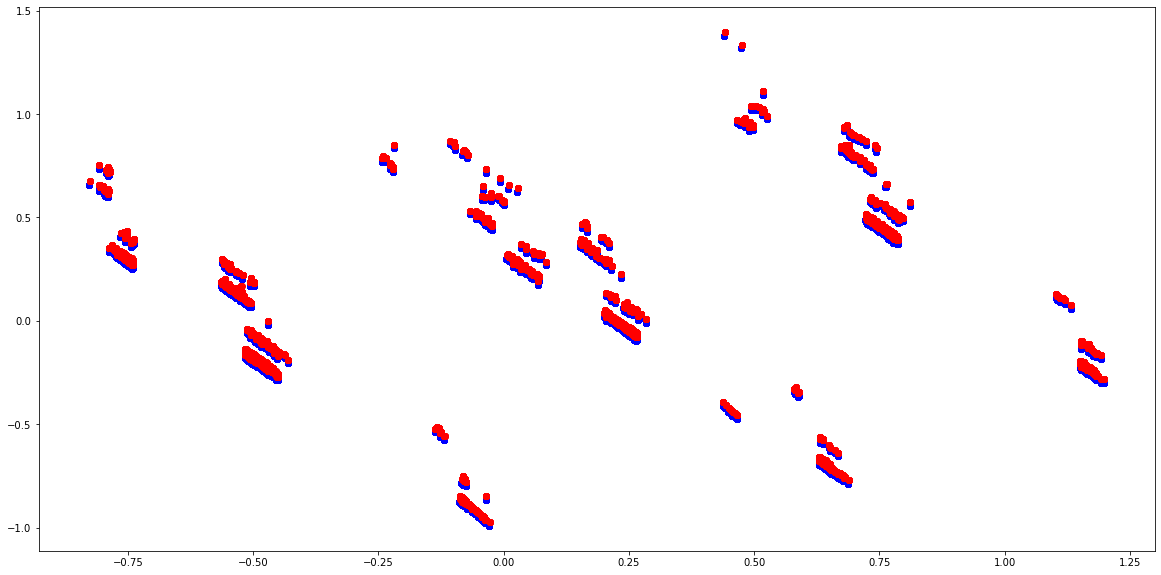

In [18]:
LOFdf=findoutliers(df,7,metrics='cosine')

In [20]:
eps=findeps(df,7,metrics='cosine')

Finding Distances
Preparing final distance
Finding EPS
Optimal eps is  0.07681051307175046


In [21]:
DBSCANdf=findoutliers(df,7,algo='DBSCAN',neps=eps,metrics='cosine')

Starting Outlier Identification
Checking if LOF has to be applied
Applying DBSCAN


MemoryError: Unable to allocate 793. KiB for an array with shape (101558, 1) and data type int64

In [22]:
LOFdf.head()

,Hour,Month,Weekday,mean_temp,rain,wind_speed,abnormal_rain,high_temp,low_temp,high_wind,EasterSundayHoliday,University_holidays,School_holidays,UKBankHoliday,InCount,Lof_Outlier,D1,D2
Date,,,,,,,,,,,,,,,,,,
01-01-2011,0.006367,0.038151,0.063493,0.094203,0.0,0.0,0,0,1,0,0,1,1,0,0.028153,1,0.466563,0.971472
01-01-2011,0.005229,0.038151,0.063493,0.094203,0.0,0.0,0,0,1,0,0,1,1,0,0.032644,1,0.466564,0.971471
01-01-2011,0.004550,0.038151,0.063493,0.094203,0.0,0.0,0,0,1,0,0,1,1,0,0.032240,1,0.466564,0.971471
01-01-2011,0.004061,0.038151,0.063493,0.094203,0.0,0.0,0,0,1,0,0,1,1,0,0.021847,1,0.466562,0.971473
01-01-2011,0.002776,0.038151,0.063493,0.094203,0.0,0.0,0,0,1,0,0,1,1,0,0.017154,1,0.466561,0.971473


In [23]:
df.head()

,Hour,Month,Weekday,mean_temp,rain,wind_speed,abnormal_rain,high_temp,low_temp,high_wind,EasterSundayHoliday,University_holidays,School_holidays,UKBankHoliday,InCount
Date,,,,,,,,,,,,,,,
01-01-2011,0.006367,0.038151,0.063493,0.094203,0.0,0.0,0,0,1,0,0,1,1,0,0.028153
01-01-2011,0.005229,0.038151,0.063493,0.094203,0.0,0.0,0,0,1,0,0,1,1,0,0.032644
01-01-2011,0.004550,0.038151,0.063493,0.094203,0.0,0.0,0,0,1,0,0,1,1,0,0.032240
01-01-2011,0.004061,0.038151,0.063493,0.094203,0.0,0.0,0,0,1,0,0,1,1,0,0.021847
01-01-2011,0.002776,0.038151,0.063493,0.094203,0.0,0.0,0,0,1,0,0,1,1,0,0.017154


In [24]:
nnear=2
eps=findeps(df,nnear,metrics='cosine')
eps=np.round(eps,decimals=3)
DBSCANdf=findoutliers(df,nnear,algo='DBSCAN',neps=eps,metrics='cosine')

Finding Distances
Preparing final distance
Finding EPS
Optimal eps is  0.010013367258796313
Starting Outlier Identification
Checking if LOF has to be applied
Applying DBSCAN


MemoryError: Unable to allocate 1021. MiB for an array with shape (324, 413168) and data type float64

In [25]:
DBSCANdf=findoutliers(df,nnear,algo='DBSCAN',neps=.01,metrics='cosine')

Starting Outlier Identification
Checking if LOF has to be applied
Applying DBSCAN


MemoryError: Unable to allocate 1021. MiB for an array with shape (324, 413168) and data type float64

In [26]:
df

,Hour,Month,Weekday,mean_temp,rain,wind_speed,abnormal_rain,high_temp,low_temp,high_wind,EasterSundayHoliday,University_holidays,School_holidays,UKBankHoliday,InCount
Date,,,,,,,,,,,,,,,
01-01-2011,0.006367,0.038151,0.063493,0.094203,0.0,0.000000,0,0,1,0,0,1,1,0,0.028153
01-01-2011,0.005229,0.038151,0.063493,0.094203,0.0,0.000000,0,0,1,0,0,1,1,0,0.032644
01-01-2011,0.004550,0.038151,0.063493,0.094203,0.0,0.000000,0,0,1,0,0,1,1,0,0.032240
01-01-2011,0.004061,0.038151,0.063493,0.094203,0.0,0.000000,0,0,1,0,0,1,1,0,0.021847
01-01-2011,0.002776,0.038151,0.063493,0.094203,0.0,0.000000,0,0,1,0,0,1,1,0,0.017154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31-12-2016,0.009032,0.056073,0.063493,0.456522,0.0,0.306667,0,0,0,0,0,1,1,0,0.010343
31-12-2016,0.009032,0.056073,0.063493,0.456522,0.0,0.306667,0,0,0,0,0,1,1,0,0.020434
31-12-2016,0.009032,0.056073,0.063493,0.456522,0.0,0.306667,0,0,0,0,0,1,1,0,0.017810


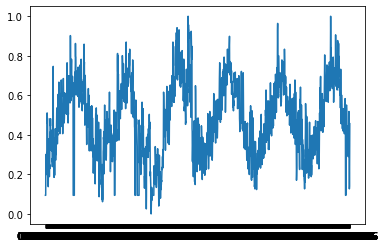

In [28]:
plt.plot(df['mean_temp'])
plt.show()

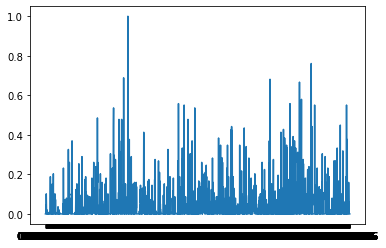

In [30]:
plt.plot(df['rain'])
plt.show()

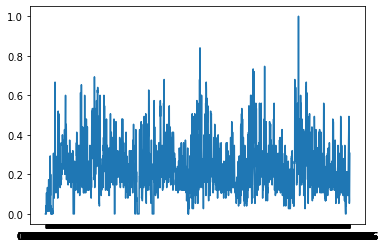

In [29]:
plt.plot(df['wind_speed'])
plt.show()